In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import os
import json
from datetime import datetime as dt
import seaborn as sns; sns.set()
from calendar import monthrange
from collections import Counter
from collections import defaultdict
import numpy as np
import spacy
import pytextrank
import tensorflow as tf
import tensorflow_hub as hub
from nltk.corpus import stopwords
import re
import squarify
import matplotlib.dates as mdates

stops = set(stopwords.words('english')) - set(['very', 'not', 'no', 'why', 'wouldn\'t', 'won\'t'])
nlp = spacy.load("en_core_web_sm")
tr = pytextrank.TextRank(token_lookback=5)
tr.load_stopwords('stop.json')
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)


SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('lines', markersize=10)
plt.rc('lines', linewidth=3)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [24]:
COLLECTION_DATE = pd.to_datetime('17 April, 2020')
EARLIEST_DATE = pd.to_datetime('31 December, 2018')
LOCKDOWN = pd.Timestamp('1 March, 2020')
MIN_REVIEWS = 0

def load_data(data_dir='../data/', consolidate=False, rating=None):
    data = []
    for fname in os.listdir(data_dir):
        if not fname[-6].isnumeric():
            continue
        fname = os.path.join(data_dir, fname)
        with open(fname) as f:
            _js_data = json.load(f)
        if rating is not None and _js_data['rating'] not in rating:
             continue
        _data = pd.DataFrame(_js_data['reviews'])
        if consolidate and _js_data['title'] != 'NHS App':
            _js_data['title'] = 'Other provider'
        _data['app'] = _js_data['title']
        data.append(_data)
    
    data = pd.concat(data)
    data['Review length'] = data.review.str.len()
    data["date"] = pd.to_datetime(data.date)
    data = data[data.date >= EARLIEST_DATE]
    return data

def groupby_month(data, order=None, reverse_order=False):
    data['Month of review'] = pd.to_datetime(data['date']) - pd.to_timedelta(7, unit='d')    
    total_reviews = data.groupby("app").count().to_dict()["Month of review"]
    if order is not None:
        total_reviews = order
    
    _df = []
    for (app, month), grouped in data.groupby(['app', pd.Grouper(key='Month of review', freq='MS')]):
        if total_reviews[app] < MIN_REVIEWS:
            continue
        _, days = monthrange(month.year, month.month)    
        if month.year == COLLECTION_DATE.year and month.month == COLLECTION_DATE.month:
            days = COLLECTION_DATE.day
        
        row = {"Reviews": len(grouped), "Reviews per day": len(grouped)/days,
               "Average review length": np.median(grouped['Review length']),
               "Month of review":month, "App": app, "Order":(1-2*int(reverse_order))*total_reviews[app]}
        _df.append(row)
    df = pd.DataFrame(_df)
    df = df.sort_values(by="Order", ascending=False)
    return df, total_reviews


def line_scatter(df, x, y):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.lineplot(x=x, y=y, hue='App', data=df, ax=ax, alpha=0.5)
    sns.scatterplot(x=x, y=y, hue='App', data=df, ax=ax, legend=False)
    ax.set_xlim(pd.Timestamp(day=1, month=1, year=2019), pd.Timestamp(day=10, month=4, year=2020))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    return ax


def generate_phrases(data):
    phrase_count = defaultdict(int)
    for i, row in data.iterrows():
        doc = nlp(row['review'])
        for p in doc._.phrases:
            if p.rank > 0:
                phrase_count[p.text] += p.rank
    return phrase_count        


def regenerate_phrases(phrase_count, thesaurus):
    _phrase_count = defaultdict(int)
    for text, count in phrase_count.items():
        text = thesaurus[text] if text in thesaurus else text
        _phrase_count[text] += count
    return _phrase_count


def remove_prefix(prefix, phrase):
    return re.sub(f"^{prefix}", "", phrase)


def remove_stop_prefixes(phrase):
    _len = len(phrase)
    for stop in stops:
        _phrase = remove_prefix(f'{stop} ', phrase)
        if len(_phrase) < _len:
            return remove_stop_prefixes(_phrase)
    return phrase


def compare(text):
    _text = [remove_stop_prefixes(terms) for terms in text]
    a = embed(_text)
    return np.inner(a, a)

def condense_phrases(text, threshold=0.79):
    #features = embed(text)
    groups = defaultdict(list)
    thesaurus = {}
    already_grouped = set()
    for irow, (term, row) in enumerate(zip(text, compare(text))):
        if irow in already_grouped:
            continue    
        for iterm, (_term, sim) in enumerate(zip(text, row)):        
            if irow == iterm or iterm in already_grouped:
                continue
            if sim > threshold:
                thesaurus[_term] = term
                groups[term].append(_term)
                already_grouped.add(iterm)
    return groups, thesaurus

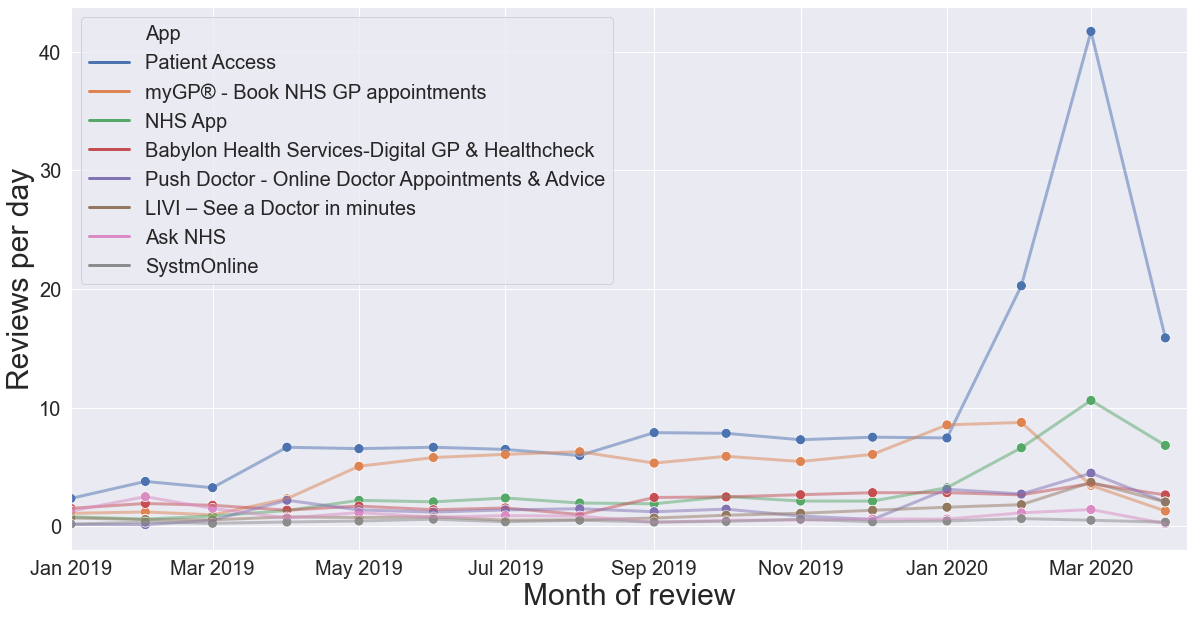

In [25]:
data = load_data()
df, order = groupby_month(data)
line_scatter(df, x='Month of review', y='Reviews per day')

low_data = load_data(rating=[1,2])
low_df, order = groupby_month(low_data, order)

mid_data = load_data(rating=[3])
high_data = load_data(rating=[3])

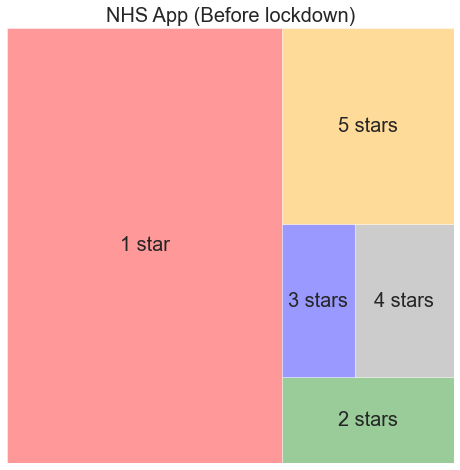

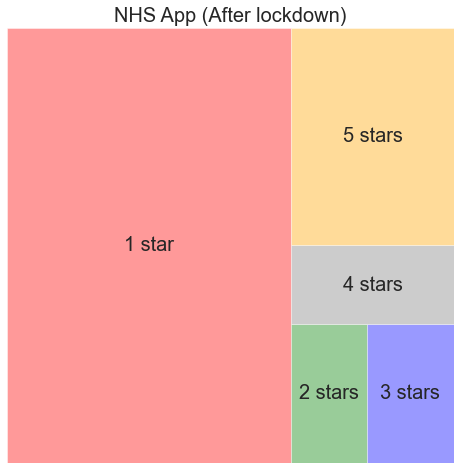

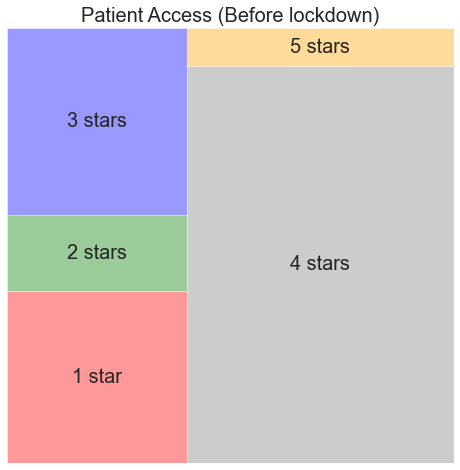

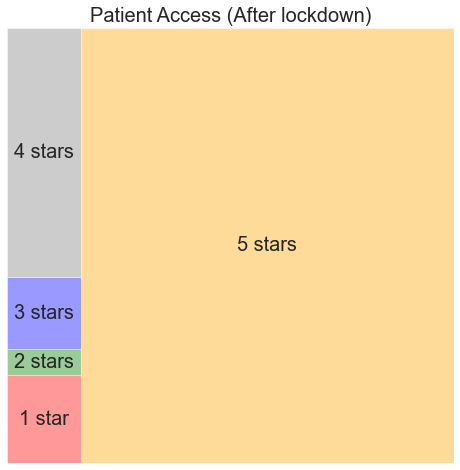

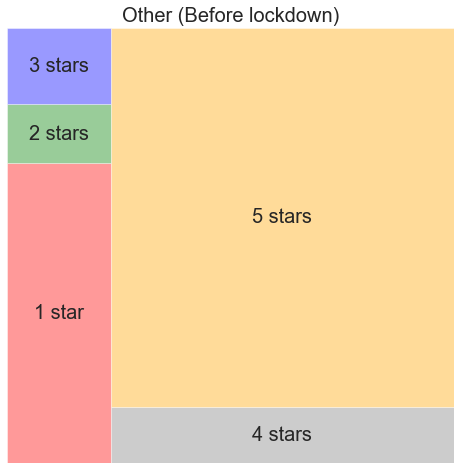

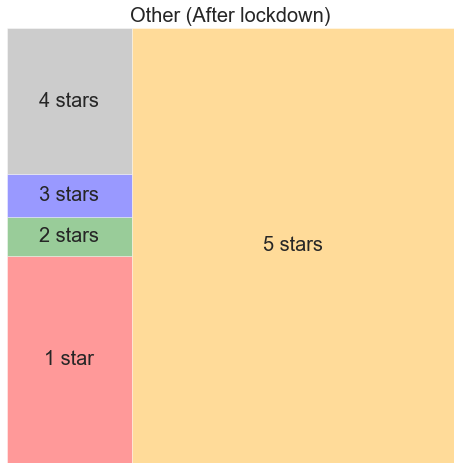

In [4]:
def rating_treemap(data, title):
    fig, ax = plt.subplots(figsize=(8,8))
    rating_counts = {f'{group} stars' if int(group) > 1 else f'{group} star': len(grouped) for group, grouped in data.groupby('rating')}    
    squarify.plot(sizes=rating_counts.values(), label=rating_counts.keys(), ax=ax, 
                  color=["red","green","blue", "grey",'orange'], alpha=.4 )
    ax.set_title(title)
    plt.axis('off')

    
slice_nhs_app = data.app == 'NHS App'
slice_patient_access = data.app == 'Patient Access'
slice_lockdown = data.date >= pd.Timestamp('1 March 2020')

slices = defaultdict(dict)
slices['NHS App']['Before lockdown'] = slice_nhs_app & ~slice_lockdown
slices['NHS App']['After lockdown'] = slice_nhs_app & slice_lockdown
slices['Patient Access']['Before lockdown'] = slice_patient_access & ~slice_lockdown
slices['Patient Access']['After lockdown'] = slice_patient_access & slice_lockdown
slices['Other']['Before lockdown'] = ~(slice_nhs_app | slice_patient_access) & ~slice_lockdown
slices['Other']['After lockdown'] = ~(slice_nhs_app | slice_patient_access) & slice_lockdown

for app_type, _slices in slices.items():
    for lockdown_type, _slice in _slices.items():
        rating_treemap(data.loc[_slice], title=f'{app_type} ({lockdown_type})')

In [5]:
## Counts of reviews by app by month
## Counts of 1 star reviews by pseudoapp by month   NOT INTERESTING
## Ratio 1:5 star reviews by pseudoapp by month

## Text length box plot vs review    # NOT INTERESTING
## Does this imply bad product = long review?   # NOT INTERESTING
## Plot total review length by pseudoapp   # NOT INTERESTING

# TextRank to identify key phrases by count
# What phrases occur before March 2020 and after March 2020 for 1-star, 2-4 star, and 5-star

# TODO
# Load data
# Subset data
# 

(-0.02, 1.75)

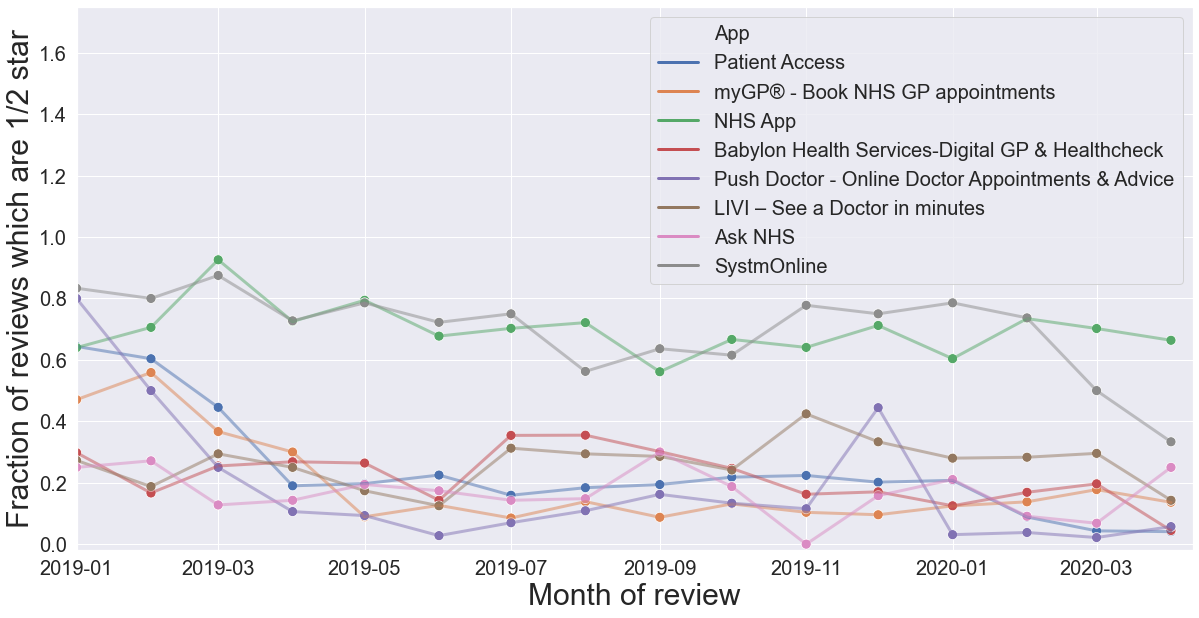

In [6]:
ratio = defaultdict(lambda: defaultdict(int))
for (month, app), grouped in low_df.groupby(['Month of review', 'App']):
    reviews = list(grouped.Reviews)
    assert len(reviews) == 1
    ratio[month][app] = reviews[0]
    
for (month, app), grouped in df.groupby(['Month of review', 'App']):
    reviews = list(grouped.Reviews)
    assert len(reviews) == 1
    ratio[month][app] = ratio[month][app] / reviews[0]

ratio = [{"Month of review":month, "App":app, "Order":order[app], "Fraction of reviews which are 1/2 star": fraction} 
         for month, _ratio in ratio.items() for app, fraction in _ratio.items()]

ratio_df = pd.DataFrame(ratio).sort_values(by="Order", ascending=False)
ax = line_scatter(ratio_df, x='Month of review', y='Fraction of reviews which are 1/2 star')
ax.set_ylim(-0.02, 1.75)

In [7]:
# ax = line_scatter(df, x='Month of review', y='Average review length')
# ax.set_xlim(pd.Timestamp(day=1, month=9, year=2019), pd.Timestamp(day=10, month=4, year=2020))
# ax.set_ylim(0, 500)

In [8]:
# fig, ax = plt.subplots(figsize=(20,10))
# sns.boxplot(x='rating', y='Review length', data=data, ax=ax)
# ax.set_ylim(0, 600)
# #sns.scatterplot(x=x, y=y, hue='App', data=df, ax=ax, legend=False)

In [9]:
phrase_count = generate_phrases(data)
_phrases = sorted((term for term, count in phrase_count.items()), key=lambda x: len(x))
groups, thesaurus = condense_phrases(_phrases)
#_phrase_count = regenerate_phrases(phrase_count, thesaurus)
#Counter(_phrase_count).most_common(50)

In [34]:
phrases_by_slice = {}
for app_type, _slices in slices.items():
    print(app_type)
    for lockdown_type, _slice in _slices.items():
        print('\t', lockdown_type)
        for ratings in [[1,2,3], [3,4,5]]:            
            title=f'{app_type} ({ratings} Ratings, {lockdown_type})'
            _data = data.loc[_slice & data.rating.apply(lambda x: int(x) in ratings)]
            phrase_count = generate_phrases(_data)
            _phrase_count = regenerate_phrases(phrase_count, thesaurus)
            phrases_by_slice[title] = _phrase_count
            print('\t\t', title)
            print('\t\t', len(title), 'reviews')
            print('\t\t', Counter(_phrase_count).most_common(20))
            print()
    break
    print()

NHS App
	 Before lockdown
		 NHS App ([1, 2, 3] Ratings, Before lockdown)
		 44 reviews
		 [('video', 7.421202735193766), ('nhs', 6.693550577161785), ('time', 6.382687930048188), ('app', 5.2402997888036404), ('appointment', 3.7930747439572086), ('photo', 3.788554617259706), ('camera', 3.4496244339465103), ('passport', 3.341994921713995), ('id', 3.0697632943211137), ('waste', 2.919638362690934), ('1st', 2.7745064982162813), ('surgery', 2.665568001321202), ('scotland', 2.5362814362305017), ('issue', 2.3695976168436954), ('login', 2.262244681590744), ('email', 2.2490102411956294), ('phone', 2.2221515467409234), ('gp', 2.2057951714333752), ('wales', 2.1987191419417087), ('a register', 2.0879916877045326)]

		 NHS App ([3, 4, 5] Ratings, Before lockdown)
		 44 reviews
		 [('appointment', 4.35323213636839), ('repeat prescription', 2.0555672426471183), ('app', 1.9254815466622444), ('time', 1.8867569347070001), ('gp', 1.6673259468372967), ('nhs', 1.5772547739976177), ('prescriptions', 1.402498

In [12]:
phrases_by_slice = {}
for app_type, _slices in slices.items():
    print(app_type)
    for lockdown_type, _slice in _slices.items():
        print('\t', lockdown_type)
        for ratings in [[1,2,3], [3,4,5]]:            
            title=f'{app_type} ({ratings} Ratings, {lockdown_type})'
            _data = data.loc[_slice & data.rating.apply(lambda x: int(x) in ratings)]
            print('\t\t', title)
            print('\t\t', len(_data))
            print()
    print()

NHS App
	 Before lockdown
		 NHS App ([1, 2, 3] Ratings, Before lockdown)
		 663

		 NHS App ([3, 4, 5] Ratings, Before lockdown)
		 274

	 After lockdown
		 NHS App ([1, 2, 3] Ratings, After lockdown)
		 377

		 NHS App ([3, 4, 5] Ratings, After lockdown)
		 155


Patient Access
	 Before lockdown
		 Patient Access ([1, 2, 3] Ratings, Before lockdown)
		 1110

		 Patient Access ([3, 4, 5] Ratings, Before lockdown)
		 2131

	 After lockdown
		 Patient Access ([1, 2, 3] Ratings, After lockdown)
		 129

		 Patient Access ([3, 4, 5] Ratings, After lockdown)
		 1757


Other
	 Before lockdown
		 Other ([1, 2, 3] Ratings, Before lockdown)
		 1025

		 Other ([3, 4, 5] Ratings, Before lockdown)
		 3575

	 After lockdown
		 Other ([1, 2, 3] Ratings, After lockdown)
		 147

		 Other ([3, 4, 5] Ratings, After lockdown)
		 668




video ['a video', 'the vid', 'my video', 'the video', 'her video', 'video link', 'your video', 'video check', 'a video clip', 'the video bit', 'the video part', 'the video record', 'the video thingy']
time ['a time', 'my time', 'the time', 'any time', 'our time', 'own time', 'this time', 'that time', 'some time', 'same time', 'more time', 'your time', 'each time', 'what time', 'only time', 'their time', 'my own time', 'all the time', 'the same time', 'your own time', 'any more time', 'time perscroptions']
nhs ['a nhs', 'nhs gp', 'nhs it', 'the nhs', 'nhs log', 'our nhs', 'free nhs', 'nhs time', 'an nhs gp', 'nhs money', 'nhs number', 'my nhs log', 'nhs doctors', 'your nhs gp', 'the nhs way', 'the nhs one', 'nhs services', 'the nhs site', 'the nhs help', 'the nhs time', 'my nhs number', 'the nhs funds', 'the nhs money', 'our great nhs', 'the whole nhs', 'most nhs docs', 'nhs unraveling', 'the nhs system', 'the nhs number', 'your nhs number', 'the nhs website', 'my nhs services', 'my nhs

(0.0, 100.0, 0.0, 100.0)

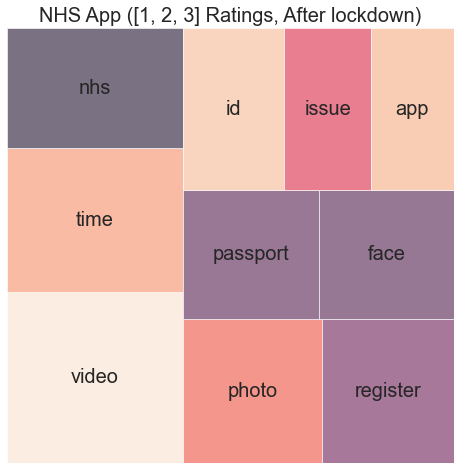

In [48]:
title = 'NHS App ([1, 2, 3] Ratings, After lockdown)'
phrases_to_plot, counts_to_plot = [],[]
for phrase, count in Counter(phrases_by_slice[title]).most_common(10):
    if phrase == 'a register':
        phrase = 'register'
    print(phrase, groups[phrase])
    phrases_to_plot.append(phrase)
    counts_to_plot.append(count)

fig, ax = plt.subplots(figsize=(8,8))
squarify.plot(sizes=counts_to_plot, label=phrases_to_plot, ax=ax, 
              alpha=.6 )
ax.set_title(title)
plt.axis('off')